# Overview

This notebook details a December 2016 attempt to implement and study Keras, a python library for "deep learning".  I follow the [Elite Data Science's tutorial on Keras and Python and CNN](https://elitedatascience.com/keras-tutorial-deep-learning-in-python).

The only substantial departures from the tutorial are:
  1. Bug fixing in specifying the expected order of dimensions received by the models. (see comments on tutorial page linked above)
  2. More exploration of what worked and what didn't work
  3. Use of TensorFlow as a backend instead of Theano.

# Imports

First we import the necessary Keras components as specified by the tutorial.

In [1]:
import numpy as np
np.random.seed(123)  # for reproducibility

from keras.models import Sequential  # a "left-to-right" sequence of layers in our NN
from keras.layers import Dense, Dropout, Activation, Flatten  # the types of layers we can have in a "regular" model
from keras.layers import Convolution2D, MaxPooling2D  # CNN type layers 
from keras.utils import np_utils

from keras.datasets import mnist  # sample data

# fixing the "bug" from the comments on the tutorial
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


The other imports are for the plotting and data munging that I do beyond what is in the tutorial.

In [2]:
# for fast histograms of discrete-classed data
from collections import Counter

# for easy conversion of collections.Counter results to numpy
from scipy import sparse

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn as sns

In [3]:
# Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Explore training data

In [4]:
print [type(x) for x in [X_train, y_train]]
print X_train.shape
print y_train.shape
print X_train.dtype
print y_train.dtype

[<type 'numpy.ndarray'>, <type 'numpy.ndarray'>]
(60000, 28, 28)
(60000,)
uint8
uint8


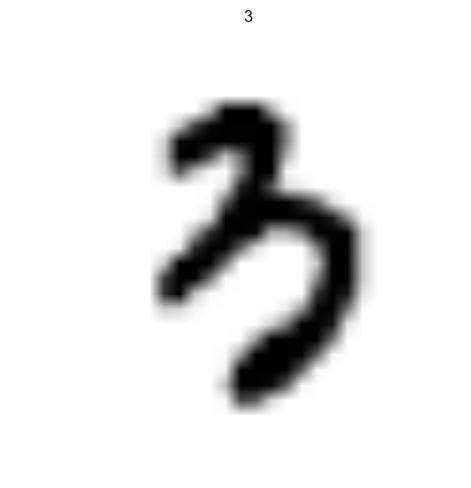

In [5]:
###
ROW = 12326  # change this value to 0 <= ROW <= 60000 to explore the data
###

plt.imshow(X_train[ROW, :, :], cmap = cmap.Greys)
plt.axis('off')
plt.title(y_train[ROW])
plt.show()

In [6]:
Counter(y_train)

Counter({0: 5923,
         1: 6742,
         2: 5958,
         3: 6131,
         4: 5842,
         5: 5421,
         6: 5918,
         7: 6265,
         8: 5851,
         9: 5949})

Thus, the data `X_train` is stack of 28&times;28 black-and-white images (i.e. matrices) that is 60,000-deep.  The datatype of the images is `uint8`.  The data `y_train` is an associated 60,000-long vector of single digit integers from 0-9.  Each image in `X_train` contains a handwritten digit, and each image in `y_train` contains the corresponding integer.  The digits are reasonably evenly represented, although there seems to be a slight excess of 1s and a dearth of 5s.

# Continuing the tutorial

## Step 5: Preprocess input data for Keras

Keras apparently works on stacks of _datacubes_, not just stacks of _matrices_.  Thus, it expects a depth parameter.  This is missing in the example image data since the data are B&W images, i.e. matrices, which have an implicit "depth" of 1.  We need to declare the depth for Keras.

In [7]:
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

In [8]:
X_train.shape

(60000, 1, 28, 28)

The tutorial says that data should be floats, not `uint8` or any other type of integer, and that the values of the data should be between 0 and 1.

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

The output data in a classification problem should be a matrix of (not necessarily mutually exclusive/orthogonal?) class membership, not a vector listing class IDs.  Keras makes this easy to fix.  (The R tidyr equivalent would be `spread()`).

# Convert 1-dimensional class arrays to 10-dimensional class matrices

In [10]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [11]:
print y_train.shape
print y_train[0, :]
print y_train.dtype

(60000, 10)
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
float64


# Step 7: Define model architecture

In [12]:
model = Sequential()

In [13]:
# first hidden layer and 32 convolutional layers
# for this syntax to work, set_image_dim_ordering('th') must be called as above in imports
model.add(Convolution2D(32, 3, 3,
                        activation='relu',
                        input_shape=(1, 28, 28)))

In [14]:
model.add(Convolution2D(32, 1, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(1,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
model.fit(X_train, 
          y_train, 
          batch_size=512,  # quick experimentation proved this to be ~5% faster on my laptop
          nb_epoch=2,  # less than the default in the tutorial to speed things up
          verbose=1)

Epoch 1/2
60000/60000 [==============================] - 350s - loss: 0.4485 - acc: 0.8658     

In [17]:
score = model.evaluate(X_test, y_test, verbose=0)
print score

[0.068696516984328632, 0.97819999999999996]


In [18]:
test_predictions = model.predict_classes(X_test, verbose=1)

10000/10000 [==============================] - 33s        64/10000 [..............................] - ETA: 35s - ETA: 30s

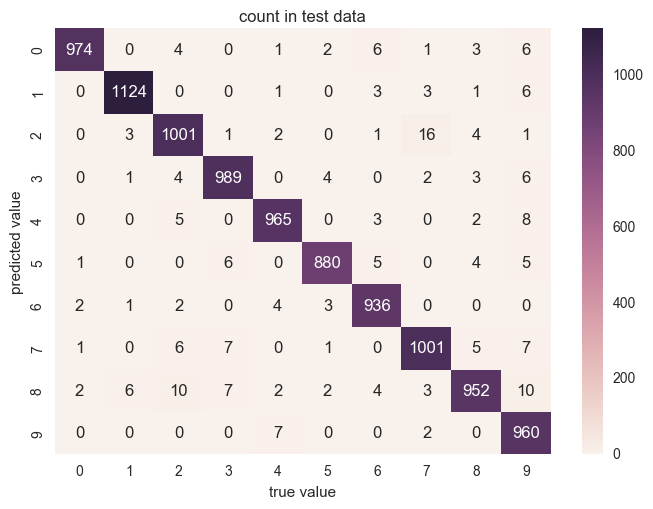

In [19]:
# load unreshaped y_test for easy comparison to ground truth
(_, _), (_, true_values) = mnist.load_data()

# a histogram of the results
results = Counter(zip(test_predictions, true_values))

# make a matrix from the histogram
err_data = results.values()
err_coords = np.asarray(results.keys(), dtype='int')
err_coords_i = err_coords[:, 0]
err_coords_j = err_coords[:, 1]

sparse_err_mat = sparse.coo_matrix((err_data, (err_coords_i, err_coords_j)))
err_mat = sparse_err_mat.todense()

# plot the data
ax = sns.heatmap(err_mat, annot=True, fmt='d')
ax.set(xlabel = 'true value', ylabel = 'predicted value', title = 'count in test data')
plt.show()


In [20]:
total_right = np.trace(err_mat)
total = np.sum(err_mat)
total_wrong = total - total_right

print (total_right, total_wrong, total)

(9782, 218, 10000)


The fitting performed very well.  The overall success rate was 9782 / 10000 or ~98%, while the error rate was 2.2%.  

The rows of `err_mat` correspond to predictions and the columns to actual values.  Thus the most common error by nearly a factor of 2 seems to be predicting a `2` when the actual value was a `7`, which occured 16 times.  Let's look at those images.  For comparison, we'll show a correctly-predicted seven directly next to it.

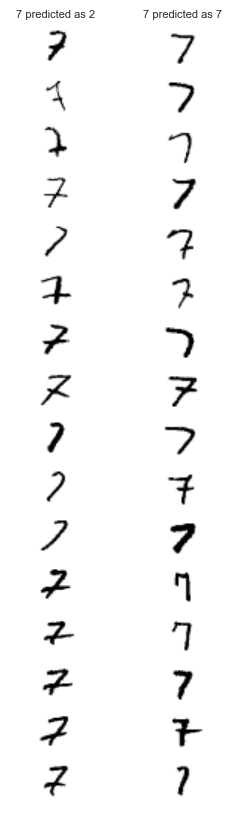

In [21]:
mistook_7_for_2_indices = []
for (index, (prediction, true_value)) in enumerate(zip(test_predictions, true_values)):
    if prediction == 2 and true_value == 7:
        mistook_7_for_2_indices.append(index)
            
# generate an equal number of correct results
n_wrong = len(mistook_7_for_2_indices)
correct_7_indices = []
for (index, (prediction, true_value)) in enumerate(zip(test_predictions, true_values)):
    if prediction == 7 and true_value == 7:
        correct_7_indices.append(index)
        if len(correct_7_indices) >= n_wrong:
            break
            
f, ax = plt.subplots(n_wrong, 2, figsize = [3, 10])

for row, _ in enumerate(ax):
    ax[row, 0].imshow(X_test[mistook_7_for_2_indices[row], 0, :, :], cmap=cmap.Greys)
    ax[row, 0].axis('off')
    ax[row, 1].imshow(X_test[correct_7_indices[row], 0, :, :], cmap=cmap.Greys)
    ax[row, 1].axis('off')
    if row == 0:
        ax[row, 0].set_title('7 predicted as 2', size = 8)
        ax[row, 1].set_title('7 predicted as 7', size = 8)
        